# XPCS Pipeline for GiSAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [1]:
from chxanalys.chx_libs import np, roi, time, datetime, os,  getpass, db, get_images,LogNorm

from chxanalys.chx_generic_functions import (get_detector, get_fields, get_sid_filenames, check_shutter_open, 
    get_each_frame_intensity, get_avg_img, load_data, load_mask,get_fields, reverse_updown, 
    apply_mask, show_img,check_ROI_intensity,run_time, cal_g2)
 
from chxanalys.XPCS_GiSAXS import (get_qedge,get_qmap_label,get_qr_tick_label, get_reflected_angles,
    convert_gisaxs_pixel_to_q, show_qzr_map, get_1d_qr, get_qzrmap, show_qzr_roi,get_each_box_mean_intensity,
    save_gisaxs_g2,plot_gisaxs_g2, fit_gisaxs_g2,plot_gisaxs_two_g2)

from chxanalys.Two_Time_Correlation_Function import Get_Pixel_Array, auto_two_Array,show_C12, get_one_time_from_two_time



%matplotlib notebook

/opt/conda_envs/analysis/lib/python3.4/site-packages/filestore/retrieve.py:15: UserWarning: Do not import filestore.retrieve, import filestore.api instead
  warnings.warn("Do not import filestore.retrieve, "


## Make a directory for saving results

In [2]:
CYCLE = '2016_2'

username = getpass.getuser()

date_path = datetime.now().strftime('%Y/%m/%d')  # e.g., '2016/03/01'
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')

##Or define data_dir here, e.g.,#data_dir = '/XF11ID/analysis/2016_2/rheadric/test/'

os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_2/yuzhang/Results/


## Load Metadata & Image Data

Print detector, scan-id, uid, datapath of data collected.

# Change these lines

In [3]:
uid = 'ffe9d518'  # 10 mTorr 1sec/frame

# Don't Change these lines below here

In [4]:
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  eiger_4M_cam_img_image_lightfield
scan_id, full-uid, data path are:  671--ffe9d518-aa6a-43d7-8eb0-17e285796e7b--/XF11ID/data/2015/11/8/3f84f57d-79b7-4a10-8b51_5


In [5]:
imgs = load_data( uid, detector  )
md = imgs.md

hdf5 path = /XF11ID/data/2015/11/8/3f84f57d-79b7-4a10-8b51_5_master.h5


In [6]:
imgs

<Frames>
Length: 15000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint32

## Overwrite Some Metadata Due to Wrong Input

In [7]:
md

{'beam_center_x': 840.0,
 'beam_center_y': 1830.0,
 'count_time': 1.0,
 'detector_distance': 4.8400002,
 'frame_time': 1.00001,
 'framerate': 0.99998998651994853,
 'incident_wavelength': 1.3776,
 'pixel_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [8]:
# The physical size of the pixels
dpix = md['x_pixel_size'] * 1000.  
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms

Ldet = 4.81        # detector to sample distance (m)

exposuretime= md['count_time']
acquisition_period = md['frame_time']

# deadtime= 0   # 60e-6 
# timeperframe = exposuretime + deadtime
timeperframe = acquisition_period  

timeperframe, exposuretime

(1.00001, 1.0)

In [9]:
setup_pargs=dict(uid=uid, dpix= dpix, Ldet=Ldet, lambda_= lambda_, 
                 timeperframe=timeperframe, )

In [10]:
setup_pargs

{'Ldet': 4.81,
 'dpix': 0.075000003562308848,
 'lambda_': 1.3776,
 'timeperframe': 1.00001,
 'uid': 'ffe9d518'}

## Apply Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change these lines

In [11]:
mask_path = '/XF11ID/analysis/2016_1/yuzhang/Results/'
mask_name = 'ffe9d518_mask.npy'

<IPython.core.display.Javascript object>


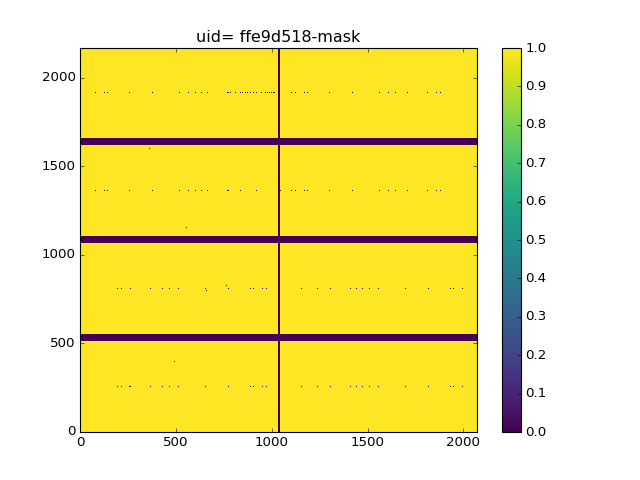

In [12]:
mask = load_mask(mask_path, mask_name, plot_ =  True, image_name = 'uid= %s-mask'%uid )

In [14]:
maskr = mask[::-1,:]
imgsr = reverse_updown( imgs )
imgsra = apply_mask( imgsr, maskr )

<IPython.core.display.Javascript object>


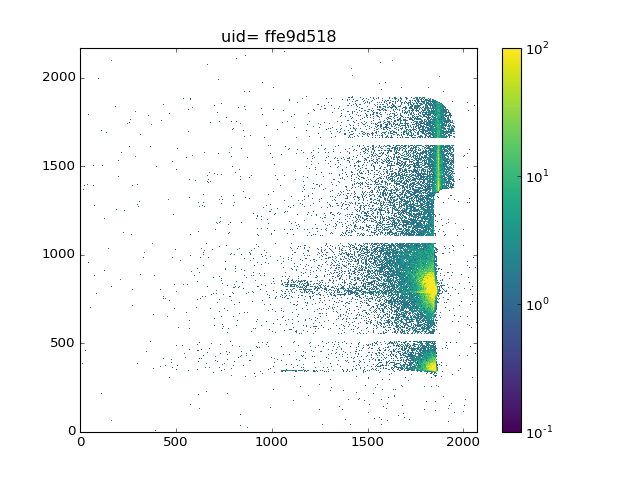

In [15]:
show_img( imgsra[0],  vmin=0.1, vmax=100, logs=True, image_name= 'uid= %s'%uid) 

## Clean Data
* Check shutter open frame to get good time series
* Find bad frames by checking total scattering intensity 


In [17]:
good_start = check_shutter_open( imgsra,  min_inten=5, time_edge = [0,10], plot_ = False )

The first frame with open shutter is : 0


In [18]:
good_series = apply_mask( imgsr[good_start:], maskr )

100%|██████████| 15/15 [00:01<00:00, 10.38it/s]


<IPython.core.display.Javascript object>


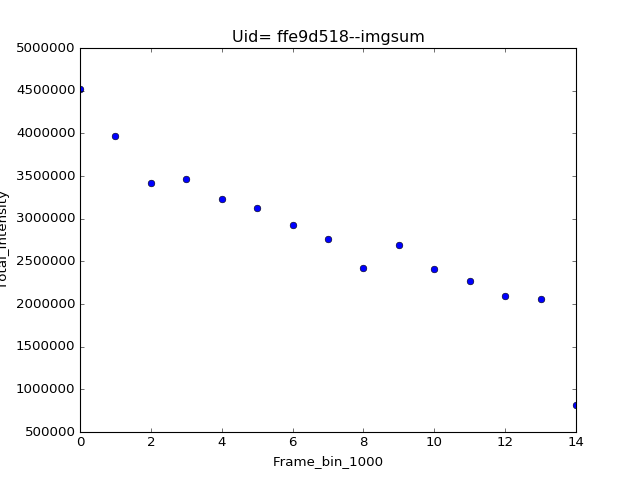

No bad frames are involved.


In [19]:
imgsum, bad_frame_list = get_each_frame_intensity(  good_series ,sampling = 1000, 
                                bad_pixel_threshold=1e14,  plot_ = True, uid=uid)

## Get intensity average image

<IPython.core.display.Javascript object>


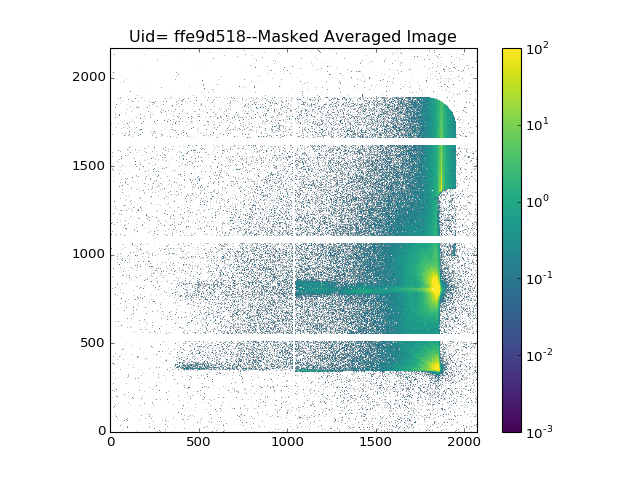

In [20]:
avg_imgr =  get_avg_img( good_series, sampling = 1000, plot_ = True, uid =uid)

## Get Q-Map (Qz and Qr)
* Users put incident-Beam and Reflection_Beam Centers here!!!

# Change these lines

In [21]:
inc_x0 = 1871
inc_y0 = 339

refl_x0 = 1871
refl_y0 = 811



# Don't Change these lines below here

In [22]:
alphaf,thetaf, alphai, phi = get_reflected_angles( inc_x0, inc_y0,refl_x0 , refl_y0, Lsd=Ldet )
qx, qy, qr, qz = convert_gisaxs_pixel_to_q( inc_x0, inc_y0,refl_x0,refl_y0, lamda=lambda_, Lsd=Ldet )

The incident_angle (alphai) is: 0.210835132612
The incident_angle (alphai) is: 0.210835132612


In [23]:
#ticks = show_qzr_map(  qr, qz, inc_x0, data = None, Nzline=10, Nrline= 10   )

<IPython.core.display.Javascript object>


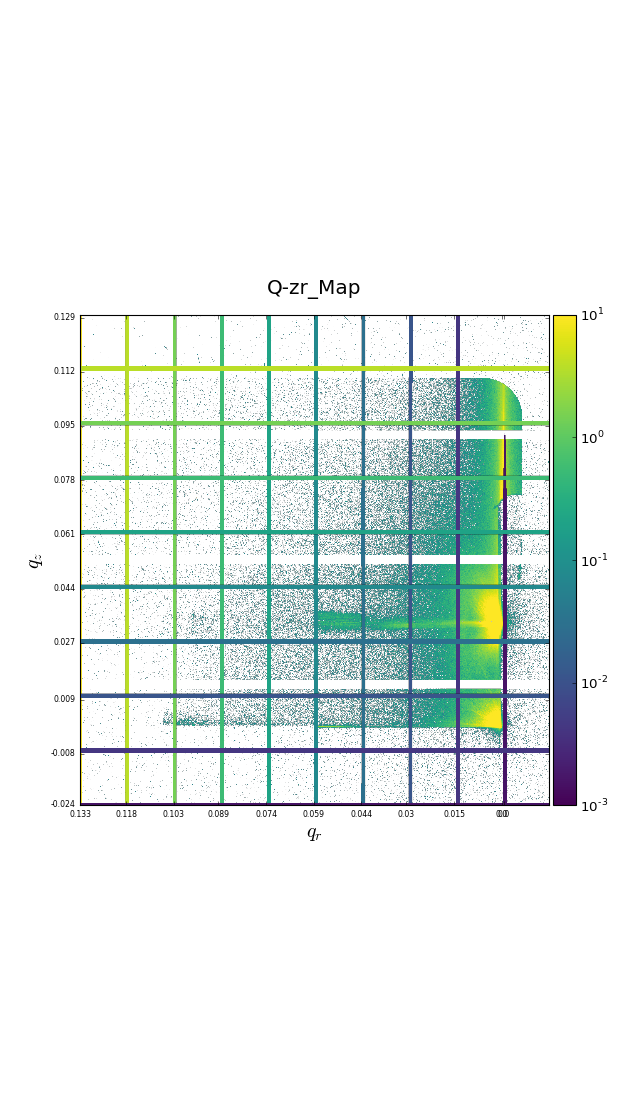

In [24]:
ticks = show_qzr_map(  qr,qz, inc_x0, data = avg_imgr, Nzline=10,  Nrline=10   )

## Get 1D Curve (Q||-intensity¶)
* Users put cuts here for static analysis

# Change these lines

In [25]:
## to make two-qz, from 0.018 to 0.046, width as 0.008, 
qz_width = 0.008
qz_num= 2

qz_start = 0.018 + qz_width/qz_num
qz_end = 0.046  -  qz_width/qz_num
 

#to make one-qr, from 0.02 to 0.1, and the width is 0.1-0.012
qr_width =  0.08
qr_start =    0.02 + qr_width  /2
qr_end =     0.01 -  qr_width  /2
qr_num = 1
 
Qr = [qr_start , qr_end, qr_width, qr_num]
Qz=  [qz_start,   qz_end,  qz_width , qz_num ]

# Don't Change these lines below here

In [26]:
new_mask = np.ones_like(avg_imgr, dtype= np.int)
new_mask[ :, 1020:1045] =0

The qr_edge is:  [ 0.02  0.1 ]
The qr_center is:  [ 0.06]
The qz_edge is:  [ 0.018  0.026  0.038  0.046]
The qz_center is:  [ 0.022  0.042]


<IPython.core.display.Javascript object>


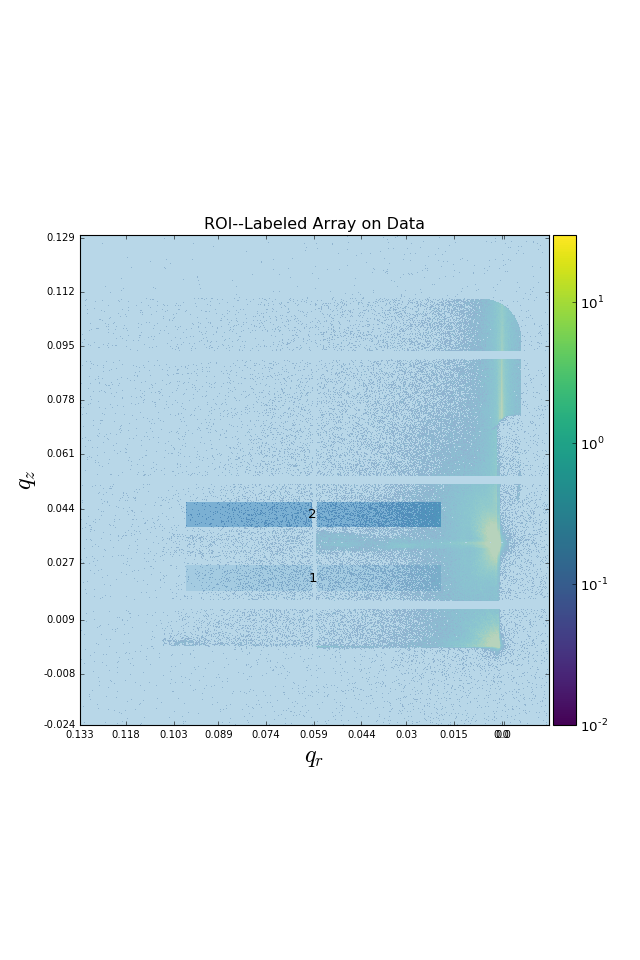

<IPython.core.display.Javascript object>


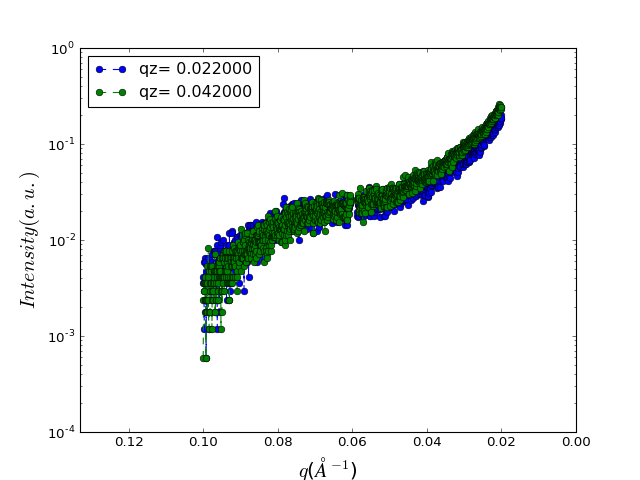

In [27]:
qr_1d = get_1d_qr( avg_imgr, Qr, Qz, qr, qz, inc_x0,  new_mask,  True, ticks, .8)

## Define Q-ROI
* User provide the interested Qz and Qr here for XPCS analysis

# Change these lines

In [28]:
qz_start = 0.022
qz_end = 0.042
qz_num= 2
qz_width = 0.008 #(qz_end - qz_start)/(qz_num +1)


qr_start =  0.01
qr_end = 0.09
qr_num = 10
qr_width = ( qr_end- qr_start)/qr_num


# Don't Change these lines below here

* Create label array (Qz, Qr, Qzr boxes)

In [29]:
qr_edge, qr_center = get_qedge(qr_start, qr_end, qr_width, qr_num )
qz_edge, qz_center = get_qedge(qz_start, qz_end, qz_width, qz_num )
      
label_array_qz = get_qmap_label(qz, qz_edge)
label_array_qr = get_qmap_label(qr, qr_edge)

label_array_qzr, qzc, qrc = get_qzrmap(label_array_qz, label_array_qr, 
                                       qz_center, qr_center)

labels_qzr, indices_qzr = roi.extract_label_indices(label_array_qzr)
labels_qz, indices_qz = roi.extract_label_indices(label_array_qz)
labels_qr, indices_qr = roi.extract_label_indices(label_array_qr)

num_qz = len(np.unique(labels_qz))
num_qr = len(np.unique(labels_qr))
num_qzr = len(np.unique(labels_qzr))

* Extract the labeled array

In [30]:
boxes = label_array_qzr 
box_maskr = boxes*maskr

qind, pixelist = roi.extract_label_indices(box_maskr)
noqs = len(np.unique(qind))

* Number of pixels in each q box

In [31]:
nopr = np.bincount(qind, minlength=(noqs+1))[1:]
nopr

array([25088, 12544, 12544, 12544, 12544, 12544, 11760, 12534, 12544,
       12544, 25088, 12544, 12544, 12544, 12544, 12544, 11760, 12544,
       12544, 12544])

* Plot average image with interested Q-regions (boxes)

<IPython.core.display.Javascript object>


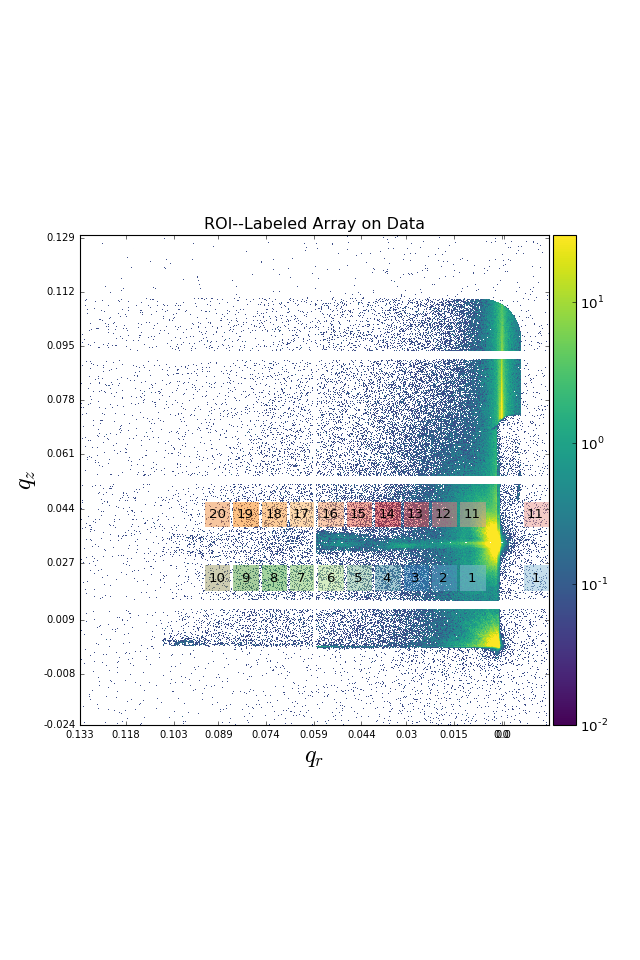

In [32]:
show_qzr_roi( avg_imgr, box_maskr, inc_x0, ticks, alpha=0.5   )

* Check one box intensity 

<IPython.core.display.Javascript object>


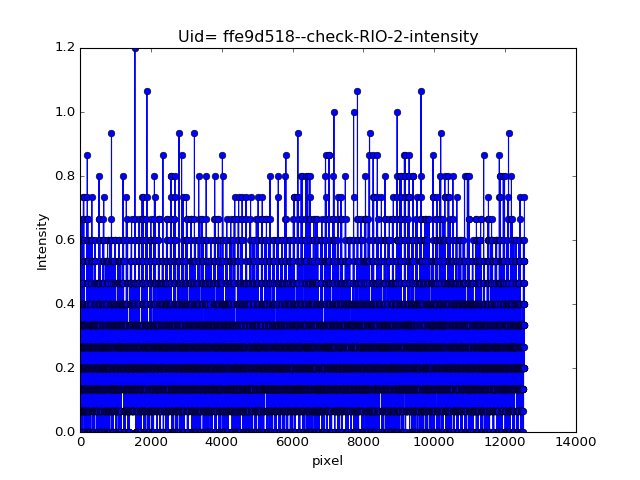

In [33]:
roi_inten = check_ROI_intensity( avg_imgr, box_maskr, ring_number= 2, uid =uid )

In [ ]:
#h1, b1 = np.histogram( roi_inten, bins = 100 )
#plot1D( h1 )

## Check beam damage
* check mean intensity of each box as a function of time

<IPython.core.display.Javascript object>


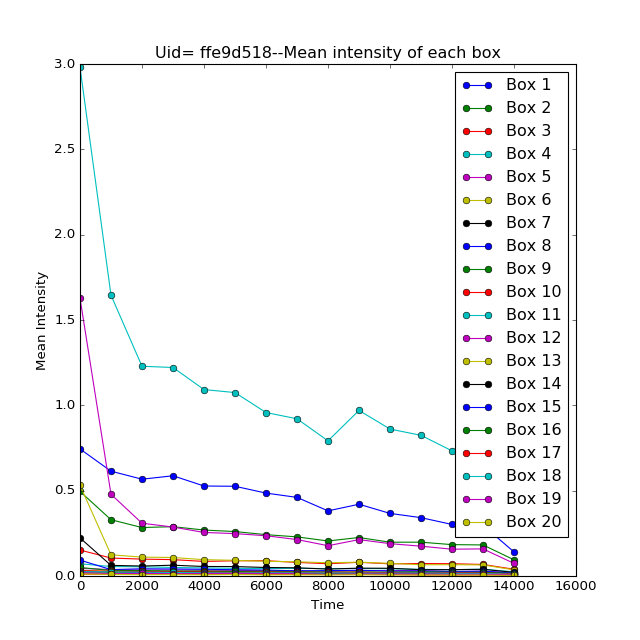

In [34]:
mean_int_sets = get_each_box_mean_intensity( good_series, box_maskr, sampling = 1000,
                                timeperframe = md['frame_time'], plot_ = True, uid=uid  )

## One time Correlation

Note : Enter the number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-beam/scikit-beam/blob/master/skbeam/core/correlation.py

In [35]:
bad_image_process = False
if  len(bad_frame_list):
    bad_image_process = True
bad_image_process 

False

### if define another good_series

In [36]:
if True:
    good_start = 10
    good_end = 100 #len( imgs )
    good_series = apply_mask( imgsr[good_start:good_end-1], maskr )

In [37]:
t0 = time.time()
g2, lag_steps  =cal_g2( good_series,  box_maskr, bad_image_process,
                       bad_frame_list,good_start, num_buf = 8 )
run_time(t0)

  0%|          | 0/89 [00:00<?, ?it/s]

In this g2 calculation, the buf and lev number are: 8--5--
89 frames will be processed...


100%|██████████| 89/89 [00:08<00:00, 10.51it/s]

G2 calculation DONE!
Total time: 0.14 min


In [41]:
taus = lag_steps * timeperframe

res_pargs = dict(taus=taus, qz_center=qz_center, qr_center=qr_center,
                 path=data_dir, uid=uid        )

In [42]:
save_gisaxs_g2(  g2, res_pargs )

The g2 of uid= ffe9d518 is saved in /XF11ID/analysis/2016_2/yuzhang/Results/ with filename as g2-ffe9d518-20160616-2054-.csv


### Plot the one time correlation functions

In [ ]:
#%matplotlib inline

<IPython.core.display.Javascript object>


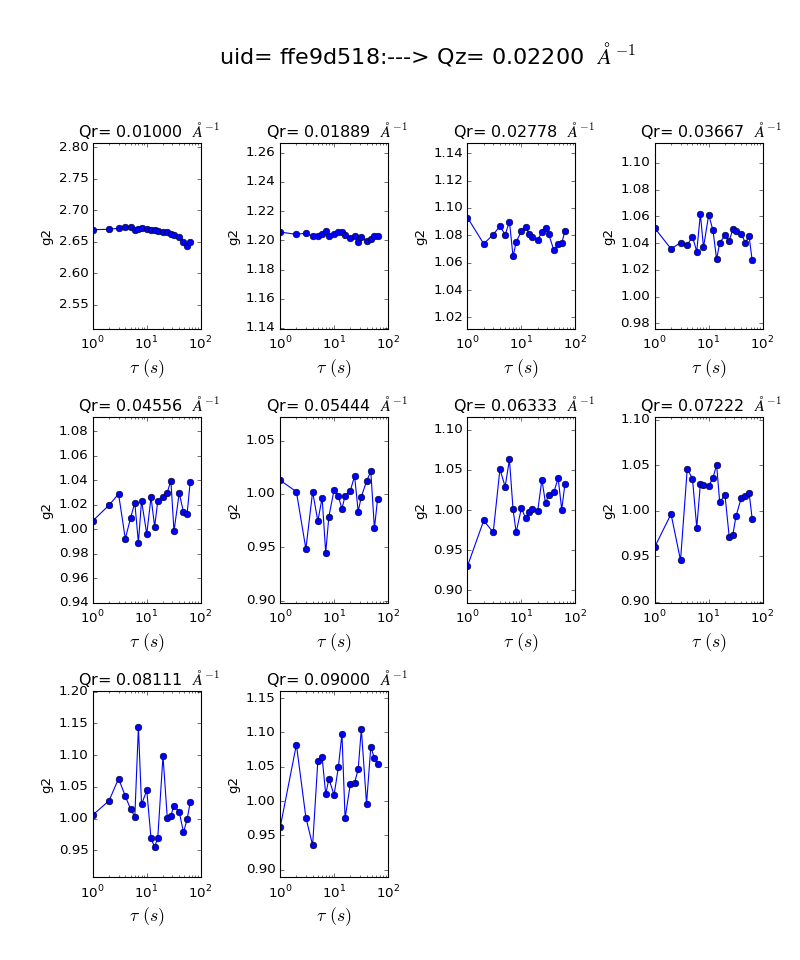

<IPython.core.display.Javascript object>


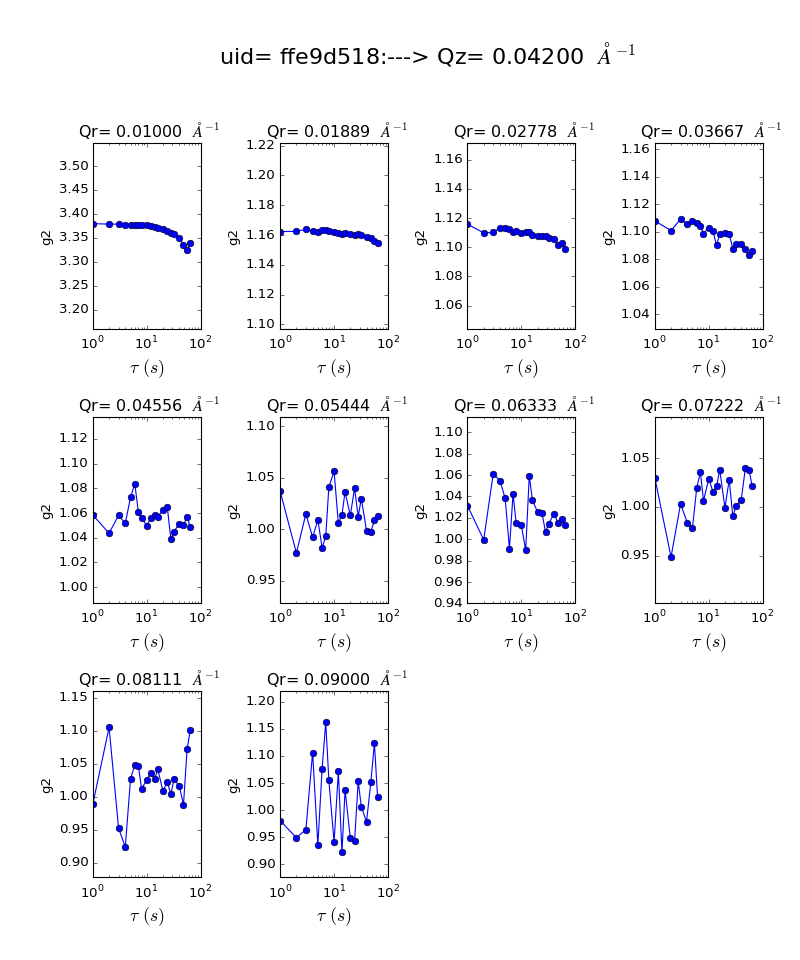

In [43]:
plot_gisaxs_g2( g2, taus,  vlim=[0.95, 1.05], res_pargs=res_pargs)              
#plot_gisaxs_g2( g2, taus,  vlim=[0.95, 1.05],qz_center=qz_center, qr_center=qr_center,uid = uid, path=path )

# Fit g2

In [44]:
fit= True

<IPython.core.display.Javascript object>


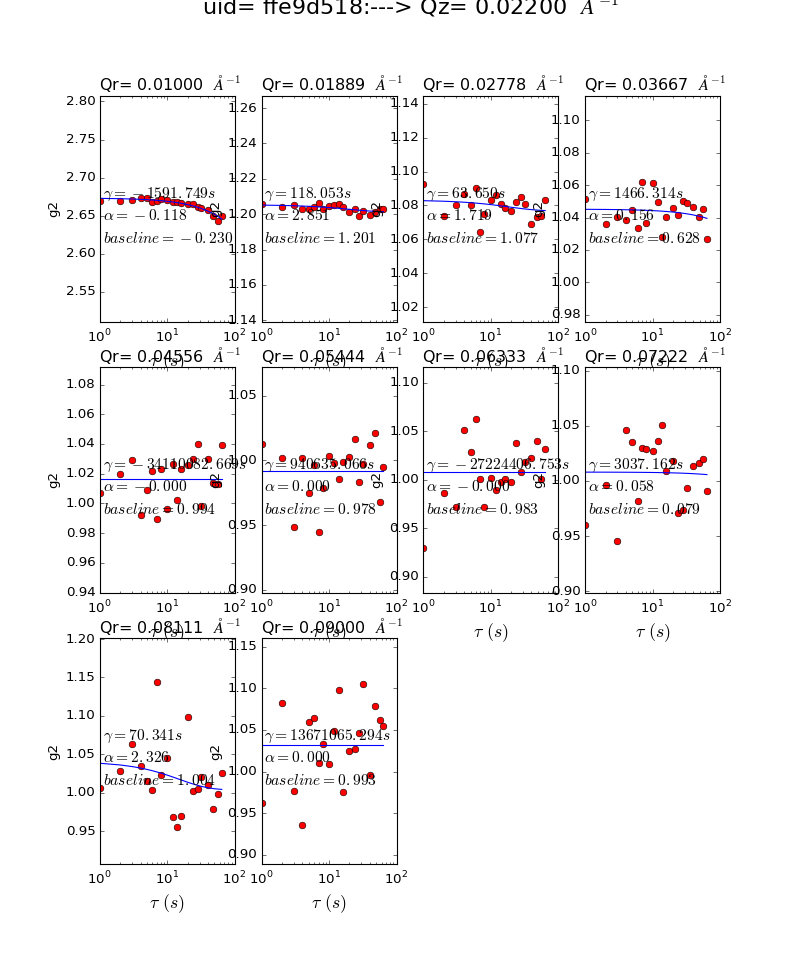

<IPython.core.display.Javascript object>


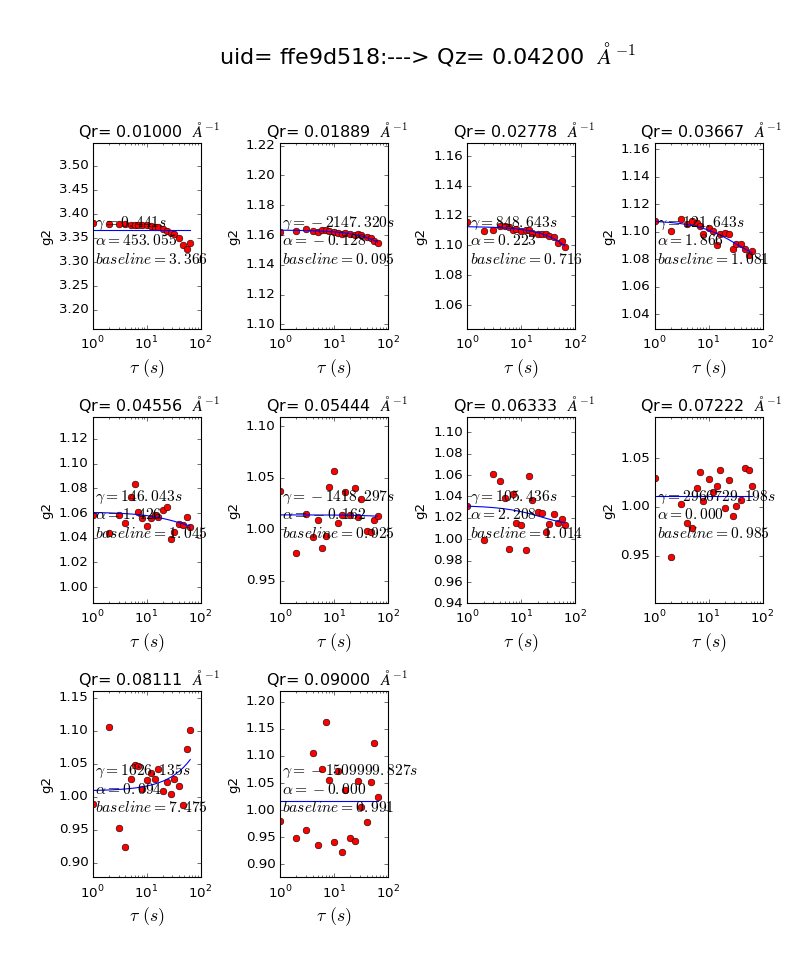

In [45]:
if fit:
    #result = fit_gisaxs_g2( g2, res_pargs, function = 'simple',  vlim=[0.95, 1.05],)
    result = fit_gisaxs_g2( g2, res_pargs, function = 'stretched',  vlim=[0.95, 1.05],)

In [ ]:
#result

# For two-time

In [39]:
run_two_time = True #False

In [40]:
if run_two_time:    
    qind, pixelist = roi.extract_label_indices(   box_maskr  )
    #good_start = 10
    #good_end = 300 #len( imgs )
    #good_series = apply_mask( imgsr[good_start:good_end-1], maskr )
    t0 = time.time()
    data_pixel =   Get_Pixel_Array( good_series , pixelist).get_data()
    
    run_time(t0)
    g12b = auto_two_Array( good_series, box_maskr, data_pixel = data_pixel ) 

 20%|██        | 4/20 [00:00<00:00, 36.79it/s]

Total time: 0.08 min


100%|██████████| 20/20 [00:00<00:00, 42.46it/s]

Total time: 0.01 min


<IPython.core.display.Javascript object>


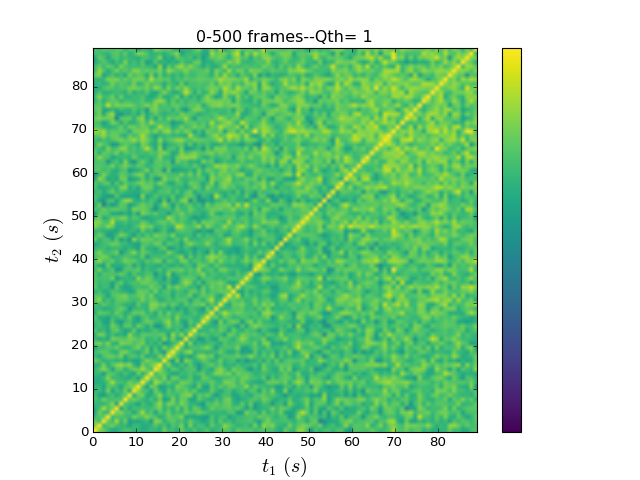

In [46]:
if run_two_time:
    show_C12(g12b, q_ind=1, N1=0, N2=500, vmin=1.006, vmax=1.29,  )

In [47]:
if run_two_time:
    g2b = get_one_time_from_two_time(g12b)

<IPython.core.display.Javascript object>


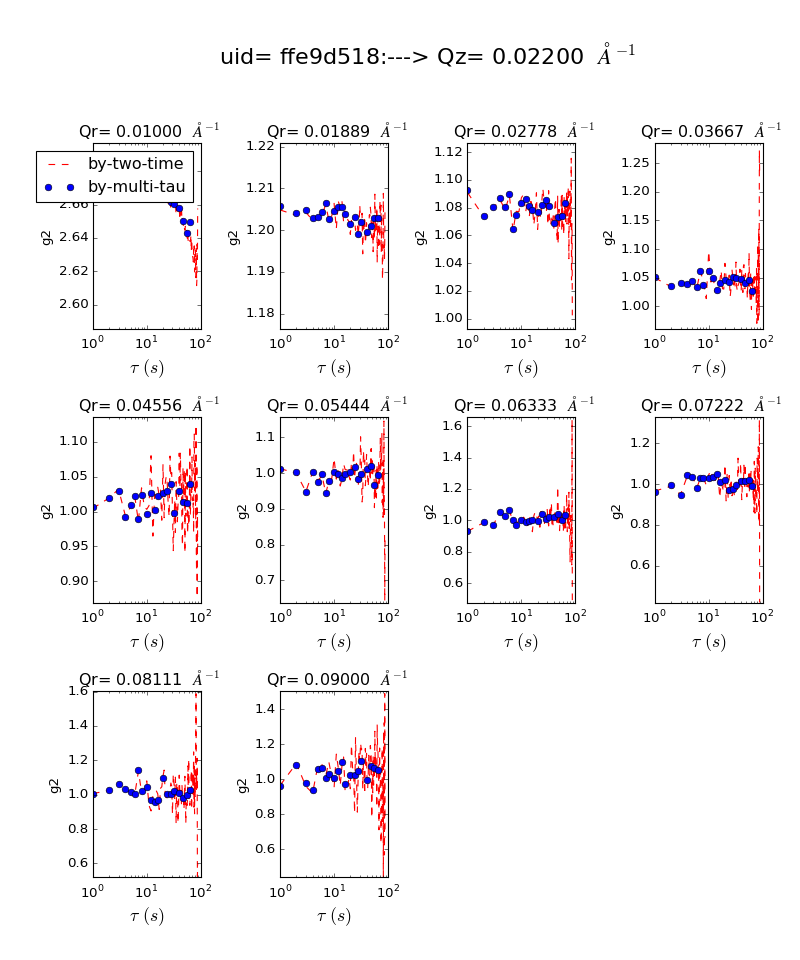

<IPython.core.display.Javascript object>


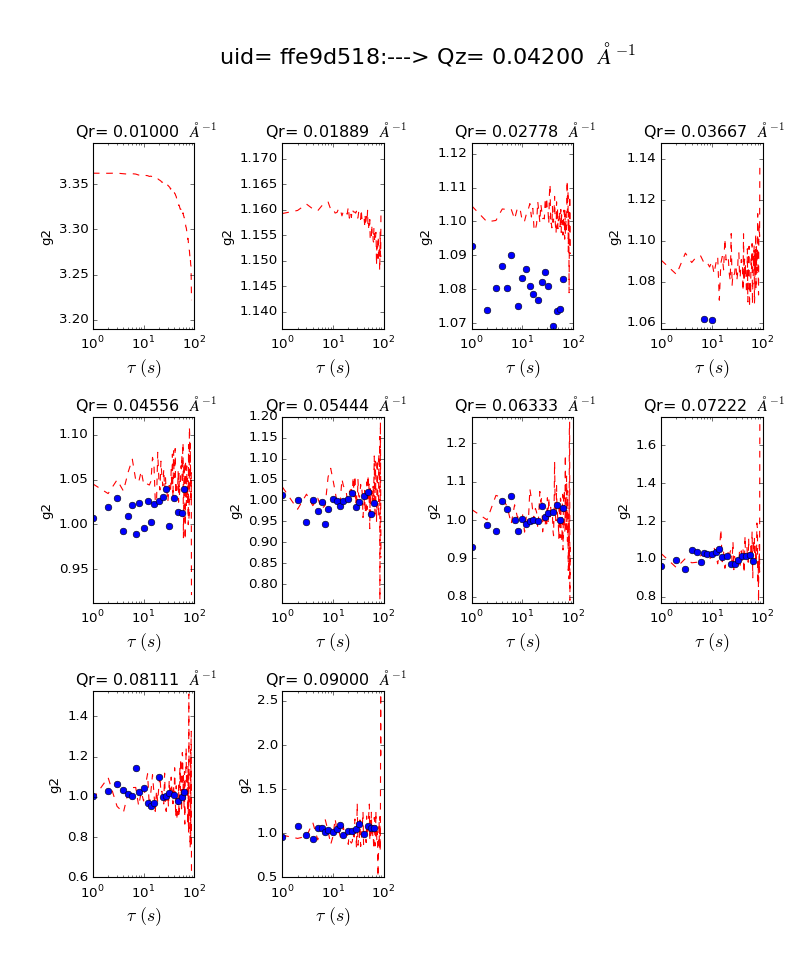

In [48]:
if run_two_time:
    plot_gisaxs_two_g2( g2, taus, 
                 g2b, np.arange( g2b.shape[0]) *timeperframe,
                 res_pargs=res_pargs, vlim=[.99, 1.01] )

# The End!